In [17]:
import numpy as np 
import pandas as pd 
import os
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy
import sklearn
import time
import os.path
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, StudentsT

In [18]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [19]:
'''
This function aims to format on-chain raw data into proper format. 
We create dummy variables which identify whether a transactions comes FROM an exchange
and / or TO an exchange
'''
def format_on_chain_df(dataframe_path, token_initials):

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    # example of dataframe path: './data/{}/raw_big_query.csv'.format{token_initials}
    df = pd.read_csv(dataframe_path.format(token_initials)) 
    df.block_timestamp = (
        df
        .block_timestamp
        .apply(
            lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') 
        )
    )
    
    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value = df.value.astype(float)

    # We create a dummy variable to identify transactions
    # from one exchange's wallet to any address   
    # If the 'from_address' at the given raw IS IN the
    # exchanges' wallet addresses, we set the value to 1
    df['_FROM_EXCHANGE'] = 0
    df.loc[df['from_address'].isin(exchange_data.Address), '_FROM_EXCHANGE'] = 1
    
    # Likewise for transactions TO exchanges
    df['_TO_EXCHANGE'] = 0    
    df.loc[df['to_address'].isin(exchange_data.Address), '_TO_EXCHANGE'] = 1
        
    trans = df
    print('We found {} transactions'.format( df.shape[0]), 'for ',dataframe_path )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]
        
    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending = False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
    
    return(trans)

In [20]:
'''
This function aims to format the off-chain raw data into a proper format
'''

def format_off_chain_df(dataframe_path, initial_date = None):
    
    price_raw = pd.read_csv(dataframe_path)
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    # if we want to start from a specific date, specify 
    # an initial_date value
    if initial_date:
        price = price.loc[price.time > initial_date]

    # "volumeto" refers to the volume in the currency that is being traded against (e.g. BTC for ETH/BTC)
    # "volumefrom" refers to the volume in the base currency that things are traded into.
    price = (
        price
        .drop(
            ['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'],
            axis=1
        )
    )
    
    # We consider the BTC volume as what we refer to as 'volume'
    price = (
        price
        .rename(columns={'volumeto':'volume'}) 
        .drop('Unnamed: 0', axis=1)
    )
    
    # filters out all zero prices
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} off-chain daily intervals.'.format( price.shape[0]) )
    
    
    return(price)

In [21]:
'''
This function aims to compute the on-chain aggregates, i.e.
since we need to match the frequency of off-chain transactions
with on-chain ones, we need to aggregate from unique transactions
to the desired aggregation level, e.g. 1 day.

We perform 'count' aggregations to obtain the number of total 
on-chain transactions of interest, and its breakdown into
transactions FROM exchanges and transactions TO exchanges.
We compute the sum of sent tokens over the desired frequency.

We return the merge of on-chain and off-chain dataframes enriched with 
the computed aggregates.

'''
def compute_aggregates(price, price_btc, trans):
        
    # We compute the returns of the closing prices
    price.loc[:,'_RETURNS'] = np.log(price['close']).diff()
    price_btc.loc[:,'_RETURNS'] = np.log(price_btc['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    min_trans_time, max_trans_time = trans.time.iloc[[0,-1]].values

    # We only keep the transactions for which we have price data
    # trans = trans.loc[(trans['time'] >= min_time)]   
    '''
    TEST PURPOSE: 
    we only keep the transactions for which we have on-chain data
    '''
    print('Current maximum off_chain time is {}'.format(max_time), 'as of {}'.format(date.today()))
    print('Current maximum on_chain time is {}'.format(max_trans_time), 'as of {}'.format(date.today()))
    price = price.loc[(price['time'] <= max_trans_time)]   
    price_btc = price_btc.loc[(price_btc['time'] <= max_trans_time)]   
            
    '''
    With the on-chain transactions,
    We create bins to match the time frequency of off-chain
    data
    ''' 
    cut = pd.cut(trans.time, bins = price.time, duplicates='drop')

    '''
    GOAL: merge on-chain and off-chain datasets.
    PROCEDURE:
    Group by the number of tokens exchanged (value) and compute the sum
    and count of this feature.
    Yields: 'onchain_volume' & '_ONCHAIN_TRANSACTIONS'
    Perform the same by grouping by 'from_exchange' dummy variable
    and taking a count of it, to obtain the number of 
    transactions coming FROM exchanges
    '''
    data = price

    for _GROUPBY in ['value','_FROM_EXCHANGE','_TO_EXCHANGE']:
        # sum variable of FROM exchanges transactions
        trans_cut = trans.groupby(cut)[_GROUPBY].aggregate(['count','sum'])
              
        # We show 5 examples of intervals for readability
        trans_cut.sample(5)
        trans_cut = trans_cut.reset_index()
        trans_cut.time = trans_cut.time.apply(lambda x:x.right)
        trans_cut.time = pd.to_datetime(trans_cut.time)
               
        data = (
            trans_cut
            .merge(data, left_on='time', right_on='time')
        )
        
        if _GROUPBY == 'value':
            data = data.rename(columns={'sum':'_ONCHAIN_VOLUME', 'count':'_ONCHAIN_TRANSACTIONS'})
            
        elif _GROUPBY == '_FROM_EXCHANGE':
            data = (
                data
                .rename(columns={'sum':'_FROM_EXCHANGE_TRANSACTIONS'})
                .drop('count', axis=1)
            )
        
        elif _GROUPBY == '_TO_EXCHANGE':
            data = (
                data
                .rename(columns={'sum':'_TO_EXCHANGE_TRANSACTIONS'})
                .drop('count', axis=1)
            )
    
    price_btc = (
        price_btc
        .rename(
            columns={
                'close':'BTC_close',
                'high':'BTC_high',
                'low':'BTC_low',
                'volume':'BTC_volume',
                '_RETURNS':'_BTC_RETURNS',
            }
        )
    )   

    data = (
        price_btc
        .merge(data, left_on='time', right_on='time')
    )

    return(data)

In [22]:
'''
We compute all features from our feature engineering procedure
'''

def compute_features(data):
    # We add an intercept for the linear regression
    data['_INTERCEPT'] = 1
    
    # Compute the set of features for the token and for BTC
    for _COL in ['','BTC_']:

        # We compute the realized volatility
        data['_' + _COL + 'REALIZED_VOL'] = (
            100 * np.sqrt(
                252 * np.square(
                    np.log(
                        data[ _COL + 'close']/data[ _COL + 'close'].shift()
                    )
                )
            )
        )

        # We compute the volatility proxy by taking the square of logreturns*100
        data['_' + _COL + 'VOL_PROXY'] = (
            np.square(data['_' + _COL + 'RETURNS']*100)
        )

        # We create a dummy variable to identify negative returns   
        data['_' + _COL + 'NEGATIVE_RETURNS'] = 0

        # If the return is negative, set it to 1, else keep the dummy variable equal to 0 
        data.loc[(data['_' + _COL + 'RETURNS'] < 0), '_' + _COL + 'NEGATIVE_RETURNS'] = 1
    
    return(data)

In [23]:
'''
This function aims to compute the GARCH model with varying parametrizations, 
plotting the results alongside AIC & BIC criteria
'''
def compute_garch(data, token_initials):
    am = ConstantMean(data['_RETURNS'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    GARCH_param = (
        pd
        .DataFrame(
            {
                'Asset' : 'Stock',
                'omega' : [res.params['omega']],
                'alpha' : [res.params['alpha[1]']],
                'beta' : [res.params['beta[1]']],
                'nu' : [res.params['nu']],
                'AIC' : [res.aic],
                'BIC' : [res.bic],
                'GARCH parameters' : [[1,0,1]]
            }
        )
    )
    
    GARCH_param.set_index('Asset', inplace = True)
    
    #display(GARCH_param)
    
    #display(res.summary())   
    
    #display(res)
    
    print('plots for GARCH(1,1)')
    fig = res.plot(annualize='D')
    '''
    Setting the 'o' variable to 1, includes one lag 
    of an asymmetric shock which transforms a GARCH model 
    into a GJR-GARCH model with variance dynamics
    '''
    for o in range(4):
        for p in range(1, 6):
            for q in range(1, 6):
                am = ConstantMean(data['_RETURNS'][1:])
                am.volatility = GARCH(p, o, q)
                am.distribution = StudentsT()

                res = am.fit(disp = 'off', update_freq = 7)
                #display(res)
                new_GARCH_param = (
                    pd
                    .DataFrame(
                        {
                            'Asset' : 'Stock',
                            'omega' : [res.params['omega']],
                            'alpha' : [res.params['alpha[1]']],
                            'beta' : [res.params['beta[1]']],
                            'nu' : [res.params['nu']],
                            'AIC' : [res.aic],
                            'BIC' : [res.bic],
                            'GARCH parameters' : [[p,o,q]]
                        }
                    )
                )
                GARCH_param = GARCH_param.append(new_GARCH_param, ignore_index = True, sort=False)

    GARCH_param['_TICKER'] = token_initials
    display(GARCH_param.sort_values(by='BIC').head(10))
    

In [24]:
'''
This function aims to display plots:
price, volume, returns of the token quoted in BTC,
as well as the moving average of:
trading volume, on-chain transaction count, on-chain transaction volume 
'''
def display_plots(data, token_initials):
    
    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    
    '''
    # Plot ACF and PACF
    plot_pacf(data._RETURNS, lags=list(range(1,48)))
    plt.title('Partial Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    plot_acf(data._RETURNS, lags=list(range(1,48)))
    plt.title('Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    '''

    nb_figures = 7
    
    # Plot price, daily return, volume
    # and moving averages of on-chain and off-chain transactions
    fig, (ax1,ax2, ax3, ax4, ax5, ax6, ax7 ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax2.set_title('Daily return of token price')
    ax2.plot(data.time, data._RETURNS)
    ax2.set_ylim((-0.3,0.3))
    
    ax3.set_title('Volatility')
    ax3.plot(data.time, data._REALIZED_VOL)
    
    ax4.set_title('Volume evolution in BTC')
    ax4.plot(data.time, data.volume)
    
    # Plots if data consist of daily intervals        
    ax5.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax5.plot(data.time,data.volume.rolling(7).mean())
    
    ax6.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax6.plot(data.time,data._ONCHAIN_TRANSACTIONS.rolling(7).mean())
    
    ax7.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax7.plot(data.time,data._ONCHAIN_VOLUME.rolling(7).mean())
    
    
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))


In [25]:
'''
This function aims to display plots:
price, volume, returns of the token quoted in BTC,
as well as the moving average of:
trading volume, on-chain transaction count, on-chain transaction volume 
'''
def display_btc_plots(data, token_initials):
    
    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    nb_figures = 5
    
    # Plot price, daily return, volume
    # and moving averages of on-chain and off-chain transactions
    fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('BTC data')
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    
    ax1.set_title('Price evolution in USDT')
    ax1.plot(data.time, data.BTC_close)
    
    ax2.set_title('Daily return of BTC price')
    ax2.plot(data.time, data._BTC_RETURNS)
    ax2.set_ylim((-0.3,0.3))
    
    ax3.set_title('Volatility')
    ax3.plot(data.time, data._BTC_REALIZED_VOL)
    
    ax4.set_title('Volume evolution in USDT')
    ax4.plot(data.time, data.BTC_volume)
    
    # Plots if data consist of daily intervals        
    ax5.set_title('Rolling 7-day exchange volume evolution in USDT')
    ax5.plot(data.time,data.BTC_volume.rolling(7).mean())   
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_btc_plots.png'.format(token_initials))


In [26]:
def compute_ML(X, y, col_name, token_initials):
    
    import sklearn
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import train_test_split
    
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler.fit(X_train_train)

    X_train_train = scaler.transform(X_train_train)
    X_train_test = scaler.transform(X_train_test)
    X_test = scaler.transform(X_test)

    '''############################ Linear Regression ##################################'''
    from sklearn.linear_model import LinearRegression

    reg = LinearRegression().fit(X_train_train, y_train_train)

    results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
    print('linear regression score of ' + col_name, reg.score(X_test, y_test))

    reg_score = reg.score(X_test, y_test)
    tokens.loc[tokens.initials == token_initials,'linear regression score of ' + col_name] = reg_score

    # Start the scatter plots here
    nb_rows = 2
    nb_columns = 1

    fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
    ax_linreg.scatter(y_test, reg.predict(X_test))
    ax_linreg.plot(y_test,y_test, 'k')
    ax_linreg.set_title(
        'Linear regression of ' + col_name 
        + ' prediction vs. true validation data token {}\n score: {:.3f} '
        .format(token_initials, reg_score)
    )
    
    # Rotates and right aligns the x labels,
    # moves the bottom of the axes up to
    # make room for them
    fig.autofmt_xdate()

    '''############################ RF Regressor ##################################'''
    from sklearn.ensemble import RandomForestRegressor

    clf = RandomForestRegressor(n_estimators = 500)
    clf = clf.fit(X_train_train, y_train_train)

    results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
    print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) ,'\n')
    clf_score = clf.score(X_test,y_test) 

    tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

    ax_tree.scatter(y_test, clf.predict(X_test))
    ax_tree.plot(y_test,y_test, 'k')
    ax_tree.set_title(
        'RF Regressor prediction of ' + col_name +
        ' vs. true validation data token {}\n score:{:.3f} '
        .format(token_initials, clf_score)
    )

    fig.autofmt_xdate()

    plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')

In [45]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import scipy
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
        
    """######################## Load the dataframe of on-chain transactions #############################"""
    
    
    df1 = format_on_chain_df('./data/{}/raw_big_query_TO_EXCHANGES.csv'.format(token_initials),token_initials)
    df2 = format_on_chain_df('./data/{}/raw_big_query_FROM_EXCHANGES.csv'.format(token_initials),token_initials)
    
    trans = (
        pd
        .concat(
            [
                df1,
                df2
            ],
            ignore_index = True
        )
        .drop_duplicates(subset = 'transaction_hash')
        .reset_index(drop = True)
    )

    print('number of on-chain transactions: ', trans.shape[0])
    print('number of duplicates: ', - (trans.shape[0] - (df1.shape[0] + df2.shape[0])),'\n')
    
    #trans = format_on_chain_df('./data/{}/raw_big_query_full.csv'.format(token_initials),token_initials)
    
    '''######################## Load the dataframe of off-chain transactions ########################'''  
    
    
    price = format_off_chain_df('./data/{}/raw_crypto_compare.csv'.format(token_initials))
    price_btc = format_off_chain_df('./data/{}/btc_raw_crypto_compare.csv'.format(token_initials))
    
    
    '''######################## COMPUTE ON-CHAIN AGGREGATES ########################'''
    
    
    data = compute_aggregates(price, price_btc, trans)
    
    
    '''######################## DATA CLEANING ########################'''
    
    # if we have daily intervals: burn the first two weeks i.e. 14 days
    data = data[14:]
    
    # We remove rows with infinite values
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) 
        .dropna()
        .reset_index()
        .drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['_RETURNS'] >= lower_bound) & (data['_RETURNS'] <= upper_bound)]

    data.sort_values('time')   
        
    '''######################## GARCH PROCEDURE ########################'''

    #compute_garch(data, token_initials)
    
    '''######################## FEATURE ENGINEERING ########################'''    
    
    data = compute_features(data)  
    
    display(data.head())
    
    '''######################## PLOTS ########################'''
    
    #display_plots(data, token_initials)
    #display_btc_plots(data, token_initials)
    
    
    '''######################## DESIGN MATRICES ########################'''    
    
    '''
    # to avoid forward looking bias, shift the columns of off-chain data:
    cols_to_shift = [
        data.high, data.low, #data._NEGATIVE_RETURNS,
        #data.volume,
        data.BTC_high, data.BTC_low,# data._BTC_NEGATIVE_RETURNS,
        #data.BTC_volume, data._BTC_RETURNS
    ]
    
    for _COL in cols_to_shift:
        _COL = _COL.shift()        
    '''

    # start from 2nd row since 1st includes NaN (e.g. from returns computation)
    y_volatility = data.iloc[1:,:]._REALIZED_VOL.values
    
    X_volatility = (
        data
        .loc[
            :,
             [
                 '_INTERCEPT', '_ONCHAIN_TRANSACTIONS', '_ONCHAIN_VOLUME',
                 'high', 'low', '_NEGATIVE_RETURNS',
                 'volume', '_FROM_EXCHANGE_TRANSACTIONS',
                 '_TO_EXCHANGE_TRANSACTIONS', 
                 
                 #'BTC_high', 'BTC_low', 'BTC_volume',
                 #'_BTC_RETURNS','_BTC_REALIZED_VOL','_BTC_NEGATIVE_RETURNS',
                 
             ]
        ]
        #.shift() # we shift all series by 1 to avoid forward-looking bias
        .iloc[1:,:] # start from 2nd row since 1st includes NaN (e.g. from returns computation)
        .values
    )   
    
    # start from 2nd row since 1st includes NaN (e.g. from returns computation)
    y_returns = data.iloc[1:,:]._RETURNS.values 
    X_returns = X_volatility
        

    '''######################## ML procedure ########################'''
    
    
    compute_ML(X_volatility, y_volatility, 'volatility', token_initials)
    
    compute_ML(X_returns, y_returns, 'returns', token_initials)


### Run the program

In [46]:
tokens = os.listdir('data')

In [47]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           #os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           # And 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]

# token_data contains all info
tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) 
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

We found 176283 transactions for  ./data/ZRX/raw_big_query_TO_EXCHANGES.csv
We found 243732 transactions for  ./data/ZRX/raw_big_query_FROM_EXCHANGES.csv
number of on-chain transactions:  417630
number of duplicates:  2385 

We have 863 off-chain daily intervals.
We have 1224 off-chain daily intervals.
Current maximum off_chain time is 2019-12-21T01:00:00.000000000 as of 2020-01-05
Current maximum on_chain time is 2019-12-23T08:00:46.000000000 as of 2020-01-05


,BTC_close,BTC_high,BTC_low,time,BTC_volume,_BTC_RETURNS,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANSACTIONS,_ONCHAIN_VOLUME,...,low,volume,_RETURNS,_INTERCEPT,_REALIZED_VOL,_VOL_PROXY,_NEGATIVE_RETURNS,_BTC_REALIZED_VOL,_BTC_VOL_PROXY,_BTC_NEGATIVE_RETURNS
0,4330.00,4400.00,4182.57,2017-08-26 02:00:00,19839.87,-0.008699,627,409,1036,1.039220e+25,...,0.000074,1062.62,-0.034045,1,NaN,11.590842,1,NaN,0.756687,1
1,4309.83,4326.27,4051.83,2017-08-27 02:00:00,1052374.12,-0.004669,379,521,900,1.134530e+25,...,0.000076,482.42,0.014438,1,22.919668,2.084568,0,7.411938,0.218003,1
2,4377.86,4433.90,4220.10,2017-08-28 02:00:00,1816507.32,0.015662,298,298,596,4.505159e+24,...,0.000075,757.05,-0.039269,1,62.338089,15.420783,1,24.861956,2.452845,0
3,4562.12,4605.34,4197.76,2017-08-29 02:00:00,2603649.16,0.041227,644,434,1078,9.373592e+24,...,0.000076,763.06,0.007050,1,11.191944,0.497062,0,65.446480,16.996991,0
4,4566.93,4639.04,4394.99,2017-08-30 02:00:00,2323879.98,0.001054,481,389,870,7.384025e+24,...,0.000073,617.25,-0.079614,1,126.383565,63.384148,1,1.672822,0.011105,0


linear regression score of volatility 0.060926865114143476
RF Regressor score of volatility -2.5434694130934172 

linear regression score of returns 0.36887457059610607
RF Regressor score of returns -0.8600980720175315 



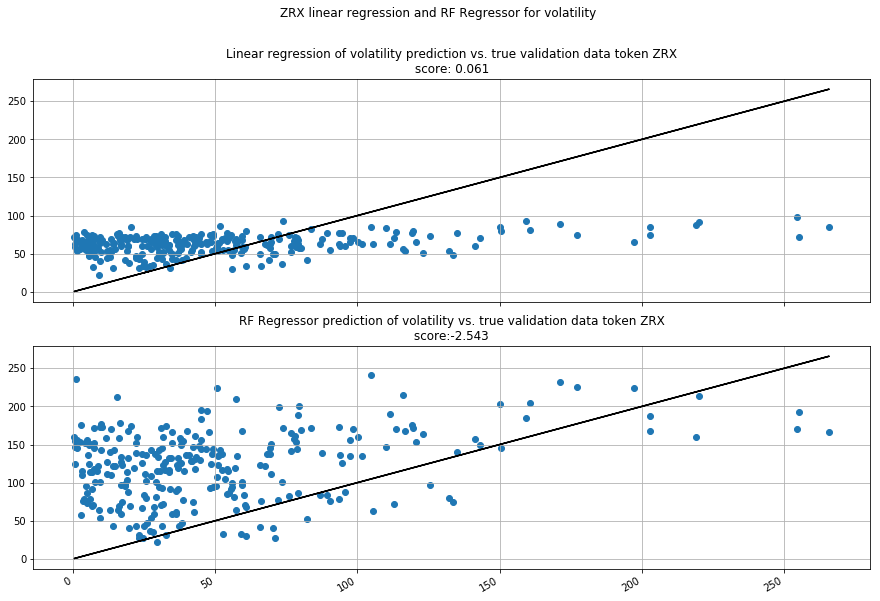

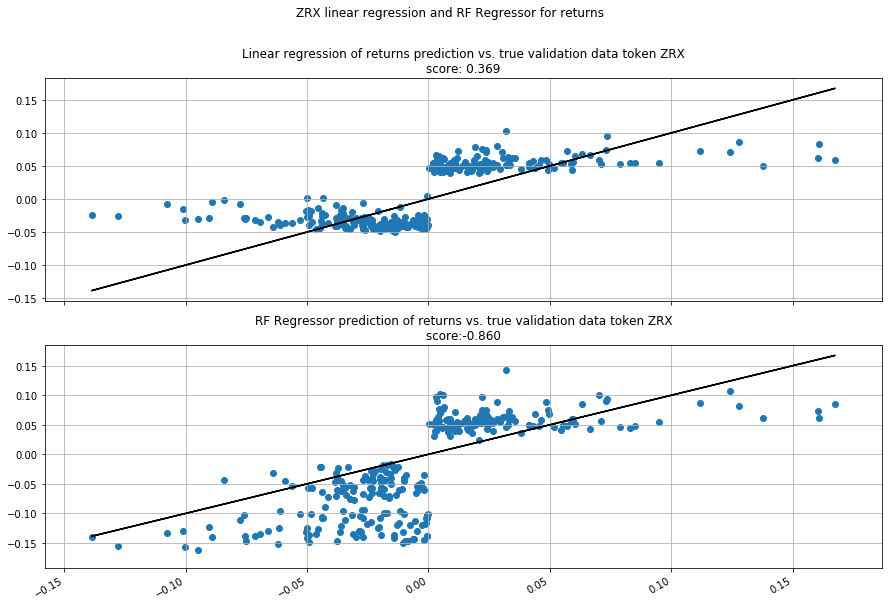

In [48]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')